# HyperbolicSystems

$$
\frac{d\vec u}{dt} + A\frac{d\vec u}{dx} = 0\\
\vec{u}|_{t=0}=\vec{u_0}(x)
$$

### 1. Диагонализируем матрицу. Для этого найдем собственные числа и левые собственные векторы.

$$l_kA=\lambda_kl_k$$

#### Домножим слева на левый собственный вектор.

$$\frac{d}{dt}[l_k\vec u] + \lambda_k\frac{d}{dx}[l_k\vec u] = 0$$

#### Теперь можно сделать замену. Это так называемый инвариант Римана.

$$R_k = l_k\vec u$$

#### Запишем левые собственные векторы построчно в матрицу L. Тогда очевидна связь вектора-инварианта с исходными переменными.

$$\vec{R} = L\vec u$$

### 2. Таким образом мы получили n независимых уравнений переноса. Решаем их. Получаем сетки для каждого инварианта Римана. Делаем обратное преобразование в исходные переменные. Получаем нужные сеточные ответы.

$
A = \begin{bmatrix} 
1 & 0   \\ 
1 & 1   \\ 
\end{bmatrix}
$

$    
U_0(x) = \begin{bmatrix}
2 \\
1 \\
\end{bmatrix}
sin(x)
$

Тогда решение, очевидно, будет:

$
U(x, t) = \begin{bmatrix}
2 \\
1 \\
\end{bmatrix}
sin(x-t)
$

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


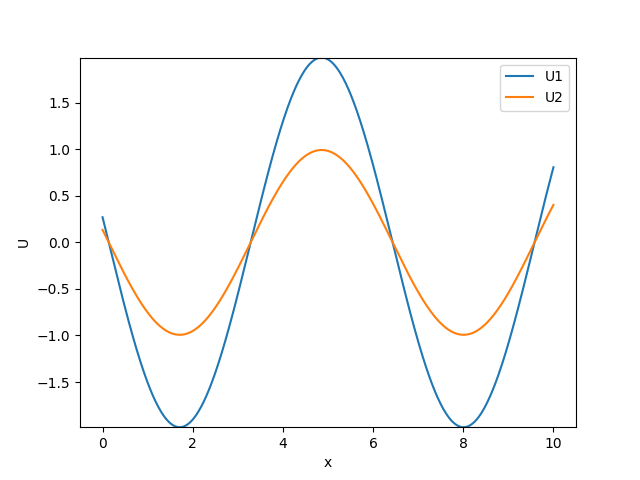

<IPython.core.display.Javascript object>


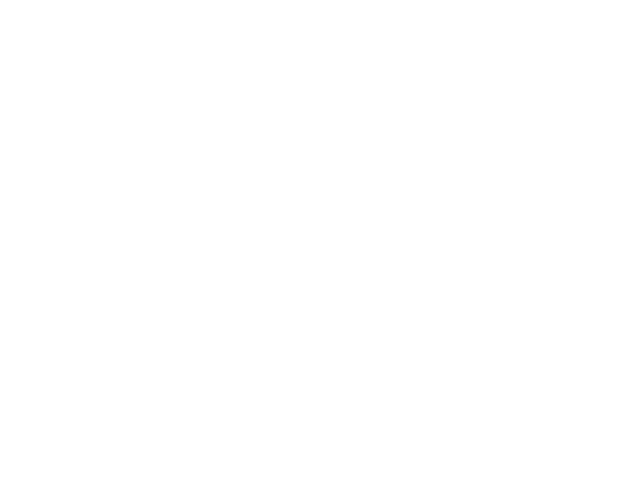

[0.9817907  5.18514508]


In [22]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import math
import random
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from mayavi import mlab
from numpy import linalg as LA
from matplotlib import animation

def solve_up(u0, a, h, tau, N, M):
    u = ([([0 for i in range(M)]) for j in range(N+M)])
    
    #u[x][t]
    
    for i in range(M+N):
        u[i][0] = u0(i*h)
#         print(u[i][0])
    
    k = tau * a / h
    for j in range (0, M-1):
        for i in range (1+j, M+N):
            u[i][j+1] = u[i][j] - k * (u[i][j] - u[i-1][j])
#     print(u)
    # shift on M need that delet zero soved
    return np.array([np.array([u[i+M][j] for j in range(M)]) for i in range(N)])

def solve(A, initFunc, h, tau, N, M):
    #self value and self vectors counted
    lambdas, va = LA.eig(A.transpose())
    L = va.transpose()
    L_1 = np.linalg.inv(L)
    
    Rs = []
    
    for k in range(len(lambdas)):
        lambdaK = lambdas[k]
        Rs.append(solve_up(lambda x: sum([initFunc(x)[i] * va[k][i] for i in range(len(lambdas))]), lambdaK, h, tau, N, M))
        
    Us = ([([[0 for _ in range(len(lambdas))] for i in range(M)]) for j in range(N)])
    for i in range(N):
        for j in range(M):
            R = []
            for k in range(len(lambdas)):
                R.append(Rs[k][i][j])

            U = L_1.dot(R)
            # U = (((va)T)-1, R) column on column
            # U = [U1, U2, U3, ..., Uk]
            Us[i][j] = U
            
    return Us

def draw(A, initFunc):
    N = 500
    M = 200
    a = 0
    b = 10
    t0 = 0
    t1 = 1
    h = (b - a) / N
    tau = (t1 - t0) / M
    xs = np.linspace(a, b, N)
    Us = solve(A, initFunc, h, tau, N, M)
    K = len(A)
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes()
    
    lines=[]     # list for plot lines for solvers and analytical solutions
    
    for i in range(K):
        #time = 0
        line, = ax.plot(xs, [Us[j][0][i] for j in range(N)], label = "U" + str(i+1))
        lines.append(line)
    
    plt.xlabel("x")
    plt.ylabel("U")
    plt.legend()
    
    # animation function.  This is called sequentially
    def animate(i):
        mx = -100
        mn = 100
        for k, line in enumerate(lines):
            arr = [Us[j][i % N][k] for j in range(N)]
            mx = max(mx, max(arr))
            mn = min(mn, min(arr))
            #update line
            line.set_data(xs, arr)
        ax.set_ylim([mn,mx])
        return [lines]
    
     
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames = np.arange(0, M, 1), interval=1, blit=False, repeat = True)
    anim.save("result.gif")
     
    plt.show()

def calcInfl(A, initFunc, trueSol, h):
    N = 100
    Us = solve(A, initFunc, h, h, N, N)
    
    K = len(A)
    err = 0
    for i in range(N):
        for j in range(N):
            for k in range(K):
                err = max(err, math.fabs(Us[i][j][k] - trueSol(i * h, j * h)[k]))
    return err

def drawInfl(A, initFunc, trueSol):
    N = 50
    hs = np.linspace(0.001, 0.01, N)
    errs = []
    
    for h in hs:
        errs.append(math.log(calcInfl(A, initFunc, trueSol, h)))
    hs = np.log(hs)
    
    fig = plt.figure()
    ax = plt.axes()
    
    plt.plot(hs, errs)
    coefs = np.polyfit(hs, errs, 1)
    print(coefs)
    plt.plot(hs, [hs[i] * coefs[0] + coefs[1] for i in range(N)])
    
    plt.show()

A = np.array([[1, 0], [0, 1]])
# A = np.array([[-1, -6], [2, 6]])

def initFunc(x):
    return math.sin(x) * np.array([2, 1])

def trueSol(x, t):
    return initFunc(x-t)

draw(A, initFunc)
drawInfl(A, initFunc, trueSol)